In [25]:
### Use the Bayesian clasifer to detect the ground in a greenhouse
### @Dr. Zhaozheng Yin, Stony Brook University, Fall 2021
### housekeeping
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [26]:
### File directory
datadir = 'data-greenhouse/Tunnel-'
trainingImages = [3]
testingImages = [1, 2]
### Parameters
scale = 32 # used to map the colors in the 256 range into a smaller range
nDim = 256 // scale # number of bins for the color likelihood distribution. This is too big. Try to have smaller bins such as 8, 16, 32, etc.

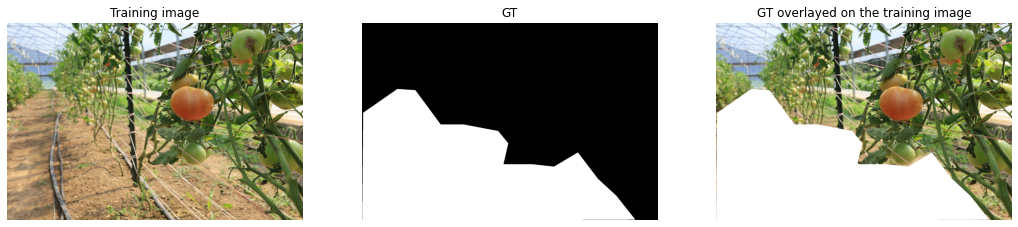

In [27]:
### Training process
Pr_x_given_y_equalsTo_1 = np.zeros((nDim,nDim,nDim)) # likelihood for the ground class
Pr_x_given_y_equalsTo_0 = np.zeros((nDim,nDim,nDim)) # likelihood for the non-ground class
N_GroundPixels = 0 # Pr_y_equalsTo_1 = N_GroundPixels/N_totalPixels
for iFile in trainingImages:
    ### Load the training image and labeled image regions
    origIm = cv2.imread(datadir + '0' + str(iFile) + '.jpg')
    labels = cv2.imread(datadir + '0' + str(iFile) + '-label.png', cv2.IMREAD_GRAYSCALE) # label=1 representing the ground class
    labels = cv2.threshold(labels, 127, 1, cv2.THRESH_BINARY)[1]

    ### Visualization input image and its labels
    nrows, ncols = origIm.shape[0], origIm.shape[1]
    N_totalPixels = nrows * ncols
    showIm = origIm.copy()
    showIm[labels==1] = 255

    ### Be sure to convert the color space of the image from BGR (Opencv) to RGB (Matplotlib) before you show a color image read from OpenCV
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(origIm, cv2.COLOR_BGR2RGB))
    plt.title('Training image')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(labels, 'gray')
    plt.title('GT')
    plt.axis("off")

    #plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(showIm, cv2.COLOR_BGR2RGB))
    plt.title('GT overlayed on the training image')
    plt.axis("off")

    plt.show()

    ### Prior-related codes:
    # preparation for calculating Pr_y_equalsTo_1
    # count the number of ground pixels in labels
    for pixels in np.nditer(labels):
        N_GroundPixels += pixels

    ### Likelihood-related codes:
    # if pixel in labels is ground, corresponding pixel in Pr_x_given_y_equalsTo_1 is incremented
    # else corresponding pixel in Pr_x_given_y_equalsTo_0 is incremented
    for r in range(nrows):
        for c in range(ncols):
            bgr = np.floor_divide(origIm[r][c], scale)
            if labels[r][c]:
                Pr_x_given_y_equalsTo_1[bgr[0]][bgr[1]][bgr[2]] += 1
            else:
                Pr_x_given_y_equalsTo_0[bgr[0]][bgr[1]][bgr[2]] += 1

### Some other codes such as normalizing the likelihood/prior and computing Pr_y_equalsTo_0:
# using the count found in prior, calculate Pr_y_equalsTo_1 and Pr_y_equalsTo_0
Pr_y_equalsTo_1 = N_GroundPixels / N_totalPixels
Pr_y_equalsTo_0 = 1 - Pr_y_equalsTo_1
# normalize Pr_x_given_y_equalsTo_1 and Pr_x_given_y_equalsTo_0
Pr_x_given_y_equalsTo_1 = np.true_divide(Pr_x_given_y_equalsTo_1, N_totalPixels)
Pr_x_given_y_equalsTo_0 = np.true_divide(Pr_x_given_y_equalsTo_0, N_totalPixels)

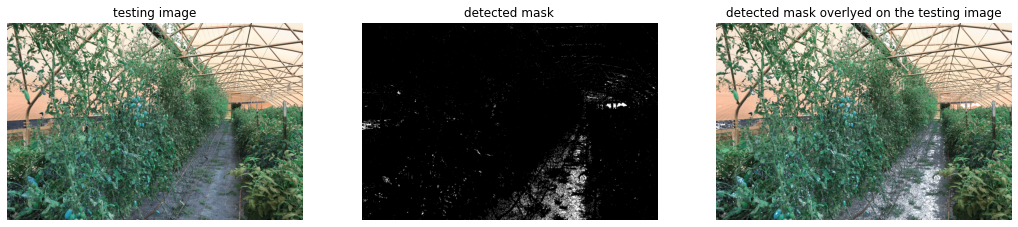

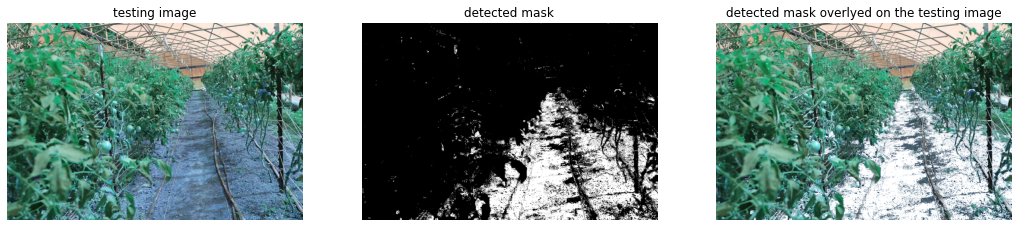

In [28]:
### Testing
truePositives = 0
falsePositives = 0
falseNegatives = 0
#testingImages = [1, 2]
for iFile in testingImages:
    ### Load the testing image and ground truth regions
    origIm = cv2.imread(datadir + '0' + str(iFile) + '.jpg')
    gtMask = cv2.imread(datadir + '0' + str(iFile) + '-label.png', cv2.IMREAD_GRAYSCALE)
    gtMask = cv2.threshold(gtMask, 127, 1, cv2.THRESH_BINARY)[1]
    #nrows, ncols = origIm.shape[0], origIm.shape[1]

    ### Define the posteriors
    Pr_y_equalsTo_1_given_x = np.zeros((nrows,ncols))
    Pr_y_equalsTo_0_given_x = np.zeros((nrows,ncols))

    ### Codes to infer the posterior:
    # omit Pr_x in calculation because it is a constant
    for r in range(nrows):
        for c in range(ncols):
            bgr = np.floor_divide(origIm[r][c], scale)
            Pr_y_equalsTo_1_given_x[r][c] = Pr_x_given_y_equalsTo_1[bgr[0]][bgr[1]][bgr[2]] * Pr_y_equalsTo_1
            Pr_y_equalsTo_0_given_x[r][c] = Pr_x_given_y_equalsTo_0[bgr[0]][bgr[1]][bgr[2]] * Pr_y_equalsTo_0

    ### Codes to obtain the final classification result (detectedMask):
    # if Pr_y_equalsTo_1_given_x >= Pr_y_equalsTo_0_given_x, ground pixel
    detectedMask = np.zeros((nrows, ncols))
    detectedMask = (Pr_y_equalsTo_1_given_x >= Pr_y_equalsTo_0_given_x)

    ### Codes to calculate the TP, FP, FN:
    # compare detectedMask with the GT
    for i, pixel in np.ndenumerate(detectedMask):
        truePositives += (pixel == gtMask[i[0]][i[1]])
        falsePositives += (pixel > gtMask[i[0]][i[1]])
        falseNegatives += (pixel < gtMask[i[0]][i[1]])

    ### Visualize the classification results
    showIm = origIm.copy()
    showIm[detectedMask==1] = 255

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(origIm)
    plt.title('testing image')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(detectedMask, 'gray')
    plt.title('detected mask')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(showIm)
    plt.title('detected mask overlyed on the testing image')
    plt.axis("off")
    plt.show()

### Codes to calculate the precision, recall, and fscore:
# find micro fscore
precision = truePositives / (truePositives + falsePositives)
recall = truePositives / (truePositives + falseNegatives)
fscore = 2 * precision * recall / (precision + recall)